# Convergent Cross Mapping / Sugihara Causality
<br>Prince Javier
<br>PhD in Data Science
<br>Asian Institute of Management

## References
**Main references**
* https://science.sciencemag.org/content/338/6106/496
* https://science.sciencemag.org/content/suppl/2012/09/19/science.1227079.DC1

**Supplementary materials**
* https://www.pnas.org/content/pnas/suppl/2016/10/26/1607747113.DCSupplemental/pnas.1607747113.sapp.pdf
* https://cran.microsoft.com/snapshot/2018-07-06/web/packages/rEDM/vignettes/rEDM-algorithms.pdf
* https://www.zora.uzh.ch/id/eprint/129395/1/Simplex_projection_walkthrough.pdf
* https://web.iitd.ac.in/~sumeet/Sahil_Parul_btp_thesis.pdf
* http://www.scholarpedia.org/article/Attractor_reconstruction

## Background

### Why understand causation?

### Correlation is not causation

### Granger's Causality works for special cases

## CCM / Sugihara Causality

### Applicability

### How and why does it work?

<CONCEPTS, illustrations, related concepts, CHARTS here>

#### Takens' Embedding Theorem

### Assumptions and Limitations

## Sample System

Explain System

Equations Here

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [95]:
# TURN THIS INTO AN EXERCISE
# SHOW ANSWERS DURING PRESENTATION
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

In [322]:
# TURN THIS INTO AN EXERCISE
# SHOW ANSWERS DURING PRESENTATION
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

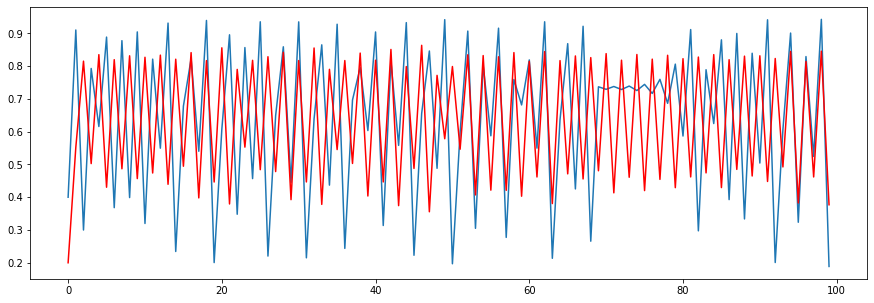

In [323]:
plt.figure(figsize=(15,5))
max_t = 100
plt.plot(X[:max_t])
plt.plot(Y[:max_t], c='r')

**Class discussion**
1. Is the system chaotic or random? Say got these data the first time without knowing the equations, which tests can we apply to check if the system is chaotic or random?
* What conclusions about causality can we infer from this plot?

array([[1.        , 0.00906338],
       [0.00906338, 1.        ]])

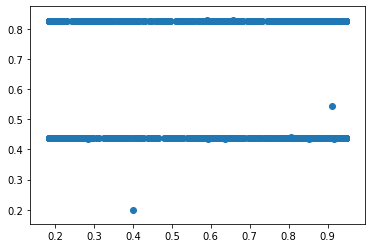

In [324]:
# correlations in the first 1000 time steps
max_t = 1000
x, y = X_all[:max_t], Y_all[:max_t]
plt.scatter(x, y)
np.corrcoef(x, y)

**Class Discussion**

Though we explicitly defined Y to be a function of X (X influences Y), we find no correlation between them in the long term. Based on this correlation value, what can we conclude about the relationship between X and Y (e.g. whether or not X influences Y or vice versa)?

In [325]:
# using Granger Causality

## CCM Algorithm

1. Given two time series $X = \{X(1), X(2), ..., X(L)\}$ and $Y = \{Y(1), Y(2), ..., Y(L)\}$ where $L$ is time series length
* Compute lagged-coordinate vectors $\underline{x}(t) = <X(t), X(t-\tau), X(t-2\tau), ..., X(t-(E-1)\tau)>$ for $t \in [1+(E-1)\tau, L]$ where $E$ is an "embedding" dimension. Search algorithms e.g. grid search can be used to identify what the best $E$ value is. $\tau$ is the lag step.
* Define the "shadow (attractor) manifold" $M_x = \{\underline{x}(t) \text{ for each } t \in [1+(E-1)\tau, L]\}$
* At $t$, locate $\underline{x}(t)$ in $M_x$
* Find the $E+1$ nearest neighbor vectors from selected vector $\underline{x}(t)$. Sugihara, et al. noted that $E+1$ is the minimum number of points needed for an "embedding/simplex" with $E$ dimensions. Intuitively, if you have a 2D matrix, you need 3 points (2 + 1) to "triangulate" a point
* Denote the time indices of the $E+1$ nearest neighbors of $\underline{x}(t)$ by $t_1, ..., t_{E+1}$. These indices will be used to identify the corresponding points in $Y$.
* Define the model that predicts $Y$ given $M_x$ as $\hat{Y} | M_x = \Sigma{w_iY(t_i)}$ where $i = 1 ... E+1$ where $w_i$ is the weight multiplied by the corresponding $Y(t_i)$
    1. $w_i = u_i / \Sigma{u_j}$ where $j = 1...E+1$
    * $u_i = exp[-d(\underline{x}(t), \underline{x}(t_i))/d(\underline{x}(t), \underline{x}(t_1))]$ where $d(\underline{x}(s), \underline{x}(t))$ is a Euclidean distance. Note that we divide by $d(x(t), x(t_1))$ to "scale" the distances as a multiples of the distance to the closest point. Though not sure why this is necessary.
* If $X$ and $Y$ are dynamically "coupled" i.e. one influences the other, a clump of points in $M_x$ should correspond to a clump of points in $M_y$. And as $L$ increases, we get a denser cluster of $E+1$ points from $M_x$ that correspond to a denser cluster of points in $M_y$. Given this, $\hat{Y} | M_x$ intuitively should converge to $Y$ as $L$ increases, e.g. we get more data/samples. Hence, we can test for convergence of the nearest neighbors to test for correspondence between states on $M_x$ and $M_y$.
* We then plot the correlation coefficients between $Y$ and $\hat{Y} | M_x$. If there is significant correlation, this means we have enough information from $Y$ that is stored in $X$. We say that $Y$ influences $X$. It sounds counter intuitive but another way to think about it is: if $Y$ influences $X$ then information from $Y$ gets stored in $X$. We can thus use $X$ to predict $Y$. Same goes for $X$ influencing $Y$.

In [326]:
def shadow_manifold(X, tau, E, L):
    """
    Args
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        Shadow attractor manifold, set of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range(1 + (E-1) * tau, L)} # shadow manifold
    for t in range(1 + (E-1) * tau, L):
        x_lag = [] # lagged values
        for t2 in range(0, E-1 + 1): # we add 1 because we want to include E
            x_lag.append(X[t-t2*tau])
        M[t] = x_lag
    return M

In [327]:
# get nearest neighbors
def get_distances(Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: distance vectors for each t_step row
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [328]:
# get nearest neighbors
def predict(Y, t, E, t_steps, dists):
    """
    Args
        Y: The time series we are trying to predict
        t: timestep of the point to compute the nearest neighbors on
        E: The embedding dimension
        t_steps: time steps from Manifold Mx, computed from get_distances
        dists: distance per vector / point from other points in Manifold Mx
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """

    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top three closest vectors
    nearest_inds = np.argsort(dist_t)[1:E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]
    
    # get weights
    u = np.exp(-nearest_distances/nearest_distances[0]) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of Y
    Y_true = Y[t] # get corresponding true Y
    Y_cor = np.array(Y)[nearest_timesteps] # get corresponding Y to cluster in Mx
    Y_hat = (w * Y_cor).sum() # get Y_hat
    
    return Y_true, Y_hat
    
    

## Analyses

In [367]:
# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)        

In [353]:
# correlations for different L values

L_range = range(5, 3100, 50) 
tau = 1
E = 2

correls = [] # correlation list
for L in L_range:
    M = shadow_manifold(X, tau, E, L) # shadow manifold
    t_steps, dists = get_distances(M) # for distances
    
    # run over all timesteps in M
    Y_true_list = []
    Y_hat_list = []

    for t in list(M.keys()):
        Y_true, Y_hat = predict(Y, t, E, t_steps, dists)
        Y_true_list.append(Y_true)
        Y_hat_list.append(Y_hat)    

    x, y = Y_true_list, Y_hat_list
    correl = np.corrcoef(x, y)[0][1]
    correls.append(correl)
    
Yhat_Mx = correls  # save to this variable   

In [354]:
# correlations for different L values
correls = [] # correlation list
for L in L_range:
    M = shadow_manifold(Y, tau, E, L) # shadow manifold
    t_steps, dists = get_distances(M) # for distances
    
    # run over all timesteps in M
    X_true_list = []
    X_hat_list = []

    for t in list(M.keys()):
        X_true, X_hat = predict(X, t, E, t_steps, dists)
        X_true_list.append(X_true)
        X_hat_list.append(X_hat)    

    x, y = X_true_list, X_hat_list
    correl = np.corrcoef(x, y)[0][1]
    correls.append(correl)

Xhat_My = correls # save to this variable

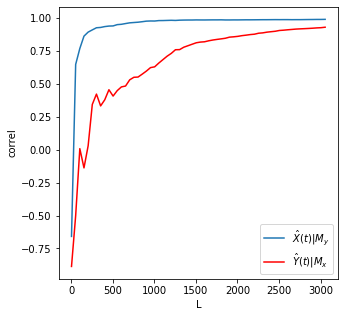

In [366]:
# plot
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L')
plt.ylabel('correl')
plt.legend()

**Class Discussion**
1. Assuming the CCM methodology is correct, what can we conclude from this plot about the interactions between $X$ and $Y$?
* Which variable has more influence on the other?

In [403]:
# Checking convergence for various betas
# params
X0 = 0.4 # initial val
Y0 = 0.4 # initial val
t = 450 # time steps
L = 400
range_ = list(np.arange(0, 0.4, 0.02)) # B ranges
correl_diffs = np.zeros(shape=(len(range_), len(range_))) # correlation list
np.random.seed(42)

for ind_B_xy in range(len(range_)): # effect on x given y (effect of y on x)
    for ind_B_yx in range(len(range_)): # effect on y given x (effect of x on y)
        
        r_x = np.random.choice(np.arange(3.6, 4.1, 0.1)) # paper implies random sampling
        r_y = np.random.choice(np.arange(3.6, 4.1, 0.1)) # paper implies random sampling

        B_xy = range_[ind_B_xy]
        B_yx = range_[ind_B_yx]
        
        # initialize dataset
        X = [X0]
        Y = [Y0]
        for i in range(t):
            X_ = func_1(X[-1], Y[-1], r_x, B_xy)
            Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
            X.append(X_)
            Y.append(Y_)        

        # compute cross mappings for X, predicting Y
        Mx = shadow_manifold(X, tau, E, L) # shadow manifold
        t_steps, dists = get_distances(Mx) # for distances

        # run over all timesteps in M
        Y_true_list = []
        Y_hat_list = []

        for t in list(Mx.keys()):
            Y_true, Y_hat = predict(Y, t, E, t_steps, dists)
            Y_true_list.append(Y_true)
            Y_hat_list.append(Y_hat) 

        # compute correlations
        x, y = Y_true_list, Y_hat_list
        correl_x = np.corrcoef(x, y)[0][1]
        
        # compute cross mappings for Y, predicting X
        My = shadow_manifold(Y, tau, E, L) # shadow manifold
        t_steps, dists = get_distances(My) # for distances

        # run over all timesteps in M
        X_true_list = []
        X_hat_list = []

        for t in list(My.keys()):
            X_true, X_hat = predict(X, t, E, t_steps, dists)
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        # compute correlations
        x, y = X_true_list, X_hat_list
        correl_y = np.corrcoef(x, y)[0][1]
        
        correl_diffs[ind_B_yx][ind_B_xy] = correl_x - correl_y

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


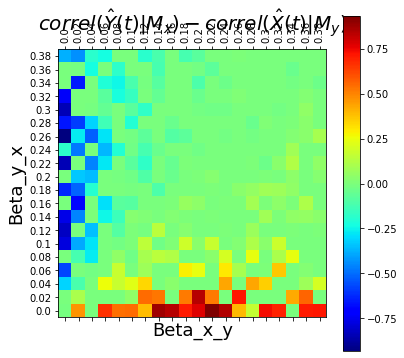

In [471]:
plt.figure(figsize=(6, 6))
plt.matshow(np.nan_to_num(correl_diffs), origin='lower', cmap='jet', fignum=1)
plt.xlabel('Beta_x_y', size=18)
plt.ylabel('Beta_y_x', size=18)
plt.title('$correl(\hat{Y}(t)|M_x) - correl(\hat{X}(t)|M_y$)', size=20)
plt.xticks(range(len(range_)), range_, rotation=90)
plt.yticks(range(len(range_)), range_)
plt.colorbar()
plt.tight_layout()
plt.show()